**Set up the Lorenz 63 system**

In [9]:
# load necessary modules
import numpy as np 
from scipy.integrate import odeint
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import matplotlib.pyplot as plt
import surrogate1 as sr1
import ftle, time
from joblib import Parallel, delayed

# Rossler system
def Rossler(u, a=0.2, b=0.2, c=5.7):
    x, y, z = u 
    p = -y - z
    q = x + a*y
    r = b + z*(x - c)
    return np.array([p, q, r])

# single trajectory generator for Rossler
def generate_trajectory(state0, dt, n_steps):
    return odeint(lambda x, t: Rossler(x), state0, np.arange(0, n_steps*dt, dt))

# multiple trajectories generator for Rossler
@ut.timer
def generate_trajectories(states0, dt, n_steps, save_folder, name):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    trajectories = np.zeros((len(states0), 3, n_steps))
    for i, state0 in enumerate(states0):
        trajectories[i, :, :] = generate_trajectory(state0, dt, n_steps).T
    np.save('{}/{}.npy'.format(save_folder, name), trajectories)

**Generate training data**

In [10]:
save_folder='../data/Rossler-trajectories'
ut.makeDir(save_folder)
dt = 0.02
n_steps = 200000

# find a point on the attractor
random_point =  np.random.normal(size=3)
attractor_point = generate_trajectory(random_point, dt, n_steps=2000)[-1]
train = generate_trajectory(attractor_point, dt, n_steps)
np.save('{}/{}.npy'.format(save_folder, 'train'), train.T)

**Generate test data**

In [11]:
num_trajectories = 500
states0 = []
for n in range(num_trajectories):
    random_point =  np.random.normal(size=3)
    attractor_point = generate_trajectory(random_point, dt, 2000)[-1]
    states0.append(attractor_point)
generate_trajectories(states0, 0.02, 2400, save_folder, 'test')

Time taken by generate_trajectories is 1.2212 seconds


**Plot the training data**

Text(0.5, 0.92, 'Rossler training data')

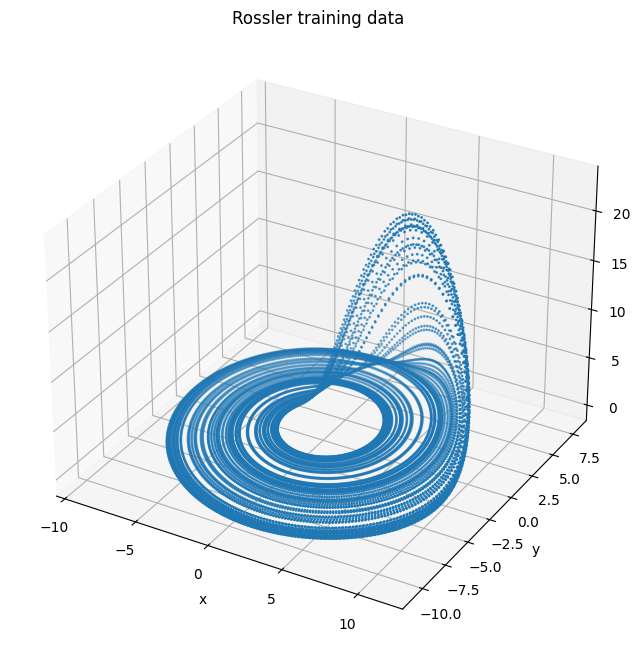

In [12]:
train = np.load('{}/{}.npy'.format(save_folder, 'train_20000'))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train[0, :], train[1, :], train[2, :], s=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Rossler training data')

**Plot the validation data**

Text(0.5, 0.92, 'Lorenz 63 validation data')

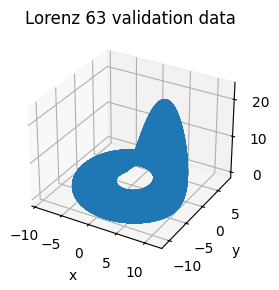

In [13]:
test = np.load('{}/{}.npy'.format(save_folder, 'validation'))

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test[0, :], test[1, :], test[2, :], s=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Lorenz 63 validation data')

**Calculate FTLEs**

In [12]:
save_folder = '../data/L63-Strategy-varying-features/'
test = np.load('../data/L63-trajectories/{}.npy'.format('test'))
all_D_r = [2**n for n in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
lyp = ftle.L63FTLE()


for D_r in all_D_r:
    start = time.time()
    bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folder+str(D_r))
    data = bsa.get_data()
    # data = data[data['good_rows_W_in']==bsa.percents[-1]] 
    T = 1. * bsa.Lyapunov_time *data['tau_f_se'].mean()
    res = Parallel(n_jobs=-1)(delayed(lyp.compute)(x0, T, 10) for x0 in test[:, :, 0])
    np.save(bsa.save_folder+'/ftle.npy', np.array(res))
    end = time.time()
    print(r'$Time taken for D_r={} and T={:.2f} is {:.4f}s$'.format(D_r, T, end-start))

$Time taken for D_r=4 and T=0.02 is 2.0177s$
$Time taken for D_r=8 and T=0.09 is 1.5585s$
$Time taken for D_r=16 and T=0.37 is 2.5131s$
$Time taken for D_r=32 and T=1.05 is 3.5863s$
$Time taken for D_r=64 and T=1.86 is 4.6702s$
$Time taken for D_r=128 and T=2.61 is 5.6673s$
$Time taken for D_r=256 and T=3.46 is 6.8964s$
$Time taken for D_r=512 and T=4.35 is 8.0862s$
$Time taken for D_r=1024 and T=5.14 is 9.1528s$
$Time taken for D_r=2048 and T=5.70 is 9.9705s$
$Time taken for D_r=4096 and T=6.14 is 10.8102s$


In [9]:
lyp.compute(np.ones(3), 5000, n_iters=5000)

0.9068654581595536

In [11]:
T

1.0989010989010988

In [1]:
2000*0.02

40.0